# Complex Networks Data Visualization
Analysis of a [Scale-Free network](https://en.wikipedia.org/wiki/Scale-free_network) based on preferential attachment with a focus on <b>VISUALIZING</b> interesting results.

### Import libraries

In [1]:
import networkx as nx
import igraph as ig
import networkx.algorithms.community as nx_comm # community detection algorithms
import numpy as np
import time
import math
import os
from scipy import stats # to do regression for the estimation of the exponent
import matplotlib.pyplot as plt
import matplotlib.cm as cm # colormaps

# set plot parameters
plt.rcParams["figure.figsize"] = (10, 10) # set figure size for network plots
plt.rcParams.update({'font.size': 15})
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.style.use('seaborn-darkgrid')

## Create the Network


A typical behaviour in real word Complex Networks, and in particular in those related to human relationships and contacts, is the <b>preferential attachment</b> mechanism. <br>

<b>Preferential attachment</b> means that the more connected a node is (e.g. the more contacts a person has), the more likely it is to receive new links. Nodes with higher degree have stronger ability to attract links added to the network.
These kind of networks are characterized by a nodes degree distribution containing a very long tale. They are also called Scale-Free (SF) networks; some examples are: social networks, computer networks, protein-protein interaction networks...

In our case, we consider the <b>Barabasi-Albert (BA)</b> model which is an algorithm for generating random SF networks using the preferential attachment mechanism.
It is based on two main principles:
* <i>Network growth</i>: the size of the network is increased starting from an initial number of nodes by incrementally adding new nodes each one with a fixed number of edges.
* <i>Preferential attachment</i>: new nodes are connected to the existing nodes according to the idea of preferential attachment, i.e. more connected nodes have more probability to attract new nodes. <br>

The BA algorithm is already implemented by the [barabasi_albert_graph()](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html) function of Networkx

### Implementation of the BA algorithm
We'll manualy implement the BA algorithm (for creating a SF network) in order to show how the preferential attachment mechanism works in detail. <br>
The Python implementation of the algorithm, by using Lists data structures and the Networkx functions is very heavy: in order to improve the performance of the algorithm, we decided to use the [Cython](https://cython.org/) extension, which allows to use C static compiling inside the Python code.

In [2]:
!pip install Cython

Be sure to install Cython extension

In [3]:
# import cython module for allowing C compilation and static binding
%load_ext Cython

#### Parameters
The algorithm has 3 input parameters: 
* n_0: number of initial nodes
* N: number of final nodes
* m: number of links for each new added node (should be m < n_0)

In [4]:
n_0 = 20
N = 500
m = 3

Let's now create the initial graph: we build a complete graph with n_0 nodes:

In [5]:
G = nx.complete_graph(n_0)

In [6]:
len(G.nodes())

20

In [7]:
# list the nodes
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

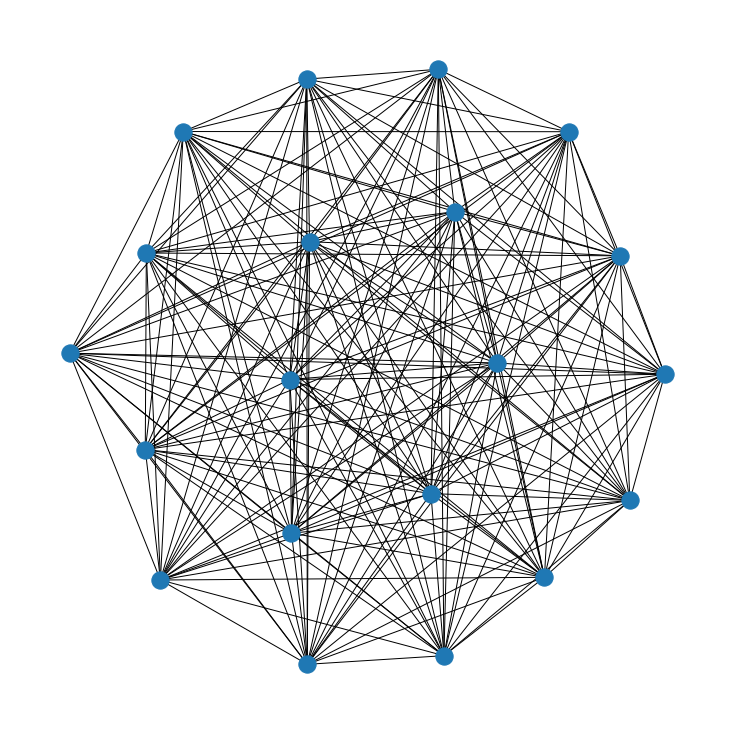

In [8]:
# Visualize the graph
nx.draw(G, node_size=300)

The plot above clearly shows the structure of a COMPLETE graph, i.e. a graph in which each node is connected to every other node.

We now need to incrementally add nodes until reaching N (we'll add nodes by increasing the number/label identifying each node). 
We use a loop to do that. After adding a node we need to add m links from it to the existing nodes, we'll use another (nested) loop to do that.

#### Auxiliary functions

Before implementing the actual code of the algorithm, lets define some helper functions for creating m links between the newly added node and the existing nodes according to the preferential attachment mechanism.

The first function we'll define builds the weighted probabilities of the graph nodes. <br>
Since this function is very expensive and it needs to be called at each inserted node during the execution of the BA algorithm, we declare it as a C function and we add also some static binding for some of the used variables. <br>
In this way we greatly improve the performance of the algorithm even when generating networks of big size.

In [9]:
%%cython
import numpy as np
import networkx as nx

# returns the list of the weighted probability of each existing node
def build_probs(G):
    nodes_probs = [] # our list
    
    # static variables
    cdef int node_deg
    cdef double node_prob
    cdef double degrees_sum = 2 * len(G.edges) # N.B.: 2 * len(G.edges) returns the sum of the degrees of all the nodes, since each edge contributes to the degree of 2 nodes
                                     
    # compute the probability for each node
    for node in G.nodes():
        node_deg = G.degree(node)
        
        # probability of the node
        node_prob = node_deg / degrees_sum 
        
        # insert into the list
        nodes_probs.append(node_prob)
    
    return nodes_probs

The 2nd auxiliary function adds m links between a node and the existing nodes, according to the preferential attachment.
We use the random.choice() function of the numpy module, which takes as input the list of nodes among which to select one and the probability associated to each node.

In [10]:
def add_links(G, added_node):
    selected_nodes = [] # list of the selected nodes
    
    # before inserting the links we build the weighted probabilities of each node
    nodes_probs = build_probs(G)
    
    # add m links
    for added_links in range(m):   
        # we use the choice function of the numpy.random module
        selected_node = np.random.choice(G.nodes(),p=nodes_probs) # selects a node according to preferential attachment
        
        # check whether the node was already selected (to avoid multiple links)
        while selected_node in selected_nodes:
            selected_node = np.random.choice(G.nodes(),p=nodes_probs) # select another node
        
        selected_nodes.append(selected_node)
        
        # once we selected the node we should create the link among the added_node given as a parameter
        # and the selected_node
        G.add_edge(added_node, selected_node)
        

#### Algorithm

In [11]:
nodes_to_add = N - n_0 # number of nodes to add until reaching N total nodes
inserted_nodes = 0 # counter of the inserted nodes

start_time = time.time()

for n_i in range(nodes_to_add):
     
    # insert new_node in the graph
    print("--------------- STEP: {} ---------------".format(inserted_nodes + 1))
    G.add_node(n_0 + inserted_nodes) # we add the node by specifying its numeric value (starting from 50)
    added_node = n_0 + inserted_nodes # identifier of the added node
    inserted_nodes += 1
    
    print("Node added: {}".format(added_node))
    # add the newly inserted node into nodes_probs because of the random.choice function to work
    
    # --------------------------------------------------------------

    # after adding the node, we need to create m links with the existing nodes 
    # according to the preferential attachment mechanism
    
    # function to add m links to the newly inserted node
    add_links(G, added_node)

elapsed_time = time.time() - start_time

--------------- STEP: 1 ---------------
Node added: 20
--------------- STEP: 2 ---------------
Node added: 21
--------------- STEP: 3 ---------------
Node added: 22
--------------- STEP: 4 ---------------
Node added: 23
--------------- STEP: 5 ---------------
Node added: 24
--------------- STEP: 6 ---------------
Node added: 25
--------------- STEP: 7 ---------------
Node added: 26
--------------- STEP: 8 ---------------
Node added: 27
--------------- STEP: 9 ---------------
Node added: 28
--------------- STEP: 10 ---------------
Node added: 29
--------------- STEP: 11 ---------------
Node added: 30
--------------- STEP: 12 ---------------
Node added: 31
--------------- STEP: 13 ---------------
Node added: 32
--------------- STEP: 14 ---------------
Node added: 33
--------------- STEP: 15 ---------------
Node added: 34
--------------- STEP: 16 ---------------
Node added: 35
--------------- STEP: 17 ---------------
Node added: 36
--------------- STEP: 18 ---------------
Node added: 37
-

Node added: 477
--------------- STEP: 459 ---------------
Node added: 478
--------------- STEP: 460 ---------------
Node added: 479
--------------- STEP: 461 ---------------
Node added: 480
--------------- STEP: 462 ---------------
Node added: 481
--------------- STEP: 463 ---------------
Node added: 482
--------------- STEP: 464 ---------------
Node added: 483
--------------- STEP: 465 ---------------
Node added: 484
--------------- STEP: 466 ---------------
Node added: 485
--------------- STEP: 467 ---------------
Node added: 486
--------------- STEP: 468 ---------------
Node added: 487
--------------- STEP: 469 ---------------
Node added: 488
--------------- STEP: 470 ---------------
Node added: 489
--------------- STEP: 471 ---------------
Node added: 490
--------------- STEP: 472 ---------------
Node added: 491
--------------- STEP: 473 ---------------
Node added: 492
--------------- STEP: 474 ---------------
Node added: 493
--------------- STEP: 475 ---------------
Node added: 49

In [12]:
print("Time required: {} seconds, {} minutes".format(elapsed_time, elapsed_time/60))

Time required: 0.2149815559387207 seconds, 0.0035830259323120115 minutes


#### Save the network

In [13]:
nx.write_pajek(G, "BA_net.net")

## Exploratory analysis
In order to better understand the network we just loaded, let's analyze some general characteristics of the net. 

In [14]:
# nodes
print(G.nodes())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [15]:
# edges
print(G.edges)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 27), (0, 50), (0, 51), (0, 58), (0, 74), (0, 95), (0, 98), (0, 144), (0, 145), (0, 158), (0, 165), (0, 174), (0, 212), (0, 237), (0, 239), (0, 243), (0, 257), (0, 291), (0, 312), (0, 322), (0, 350), (0, 355), (0, 365), (0, 366), (0, 384), (0, 385), (0, 392), (0, 396), (0, 404), (0, 441), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 23), (1, 33), (1, 38), (1, 42), (1, 44), (1, 45), (1, 56), (1, 60), (1, 63), (1, 70), (1, 93), (1, 108), (1, 121), (1, 124), (1, 134), (1, 137), (1, 142), (1, 152), (1, 176), (1, 185), (1, 200), (1, 276), (1, 280), (1, 284), (1, 337), (1, 348), (1, 366), (1, 385), (1, 388), (1, 433), (1, 443), (1, 458), (1, 461), (1, 474), (1, 493), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2,

### Network Descriptors
Let's calculate some of the most representative properties of the network. <br>

All the methods used in order to perform the calculations are implemented in the networkx library

In [16]:
print("Number of nodes: {}".format(G.number_of_nodes()))
#G.nodes()

print("Number of edges: {}".format(G.number_of_edges()))
#G.edges()

degrees_values = [val for key,val in G.degree()] # degree for each node
#degrees_values

print("Min degree: {}".format(np.min(degrees_values)))
print("Max degree: {}".format(np.max(degrees_values)))
print("Avg degree: {}".format(round(np.mean(degrees_values), 4)))
#G = nx.Graph(G)

print("Clustering: {}".format(round(nx.average_clustering(G), 4)))
print("Assortativity: {}".format(round(nx.degree_assortativity_coefficient(G), 4)))
if nx.is_connected(G):
    print("Avg path length: {}".format(round(nx.average_shortest_path_length(G), 4)))
    print("Diameter: {}".format(nx.diameter(G)))

Number of nodes: 500
Number of edges: 1630
Min degree: 3
Max degree: 74
Avg degree: 6.52
Clustering: 0.1861
Assortativity: -0.0606
Avg path length: 2.9082
Diameter: 5


### Plot the net
At first, let's try to plot the network, even if the visualization will be difficult due to the high number of edges and nodes.<br>
In order to obtain a clearer plot we will use the layout algorithm proposed by Kamada-Kawai which renders the network with minimal edge-overlapping.<br>
Original paper: https://doi.org/10.1016/0020-0190(89)90102-6<br> <br>
This will allow us to use always the same positioning for the nodes in all the plots we'll perform.

In [17]:
pos = nx.kamada_kawai_layout(G)

We use the Networkx [draw()](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw) function, which takes in input also the positioning of the nodes (the one we obtained by applying Kamada-Kawai nodes positioning): 

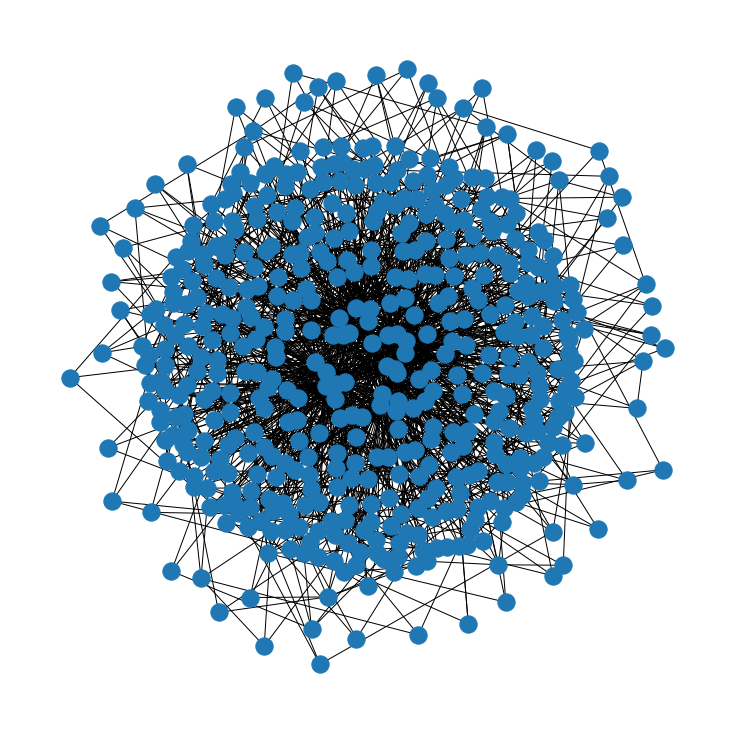

In [18]:
nx.draw(G, pos=pos)

To improve the above plot, we can try to reduce the size of the nodes, the width of the edges and we can also use a lighter colour for the edges, instead of the standard black:

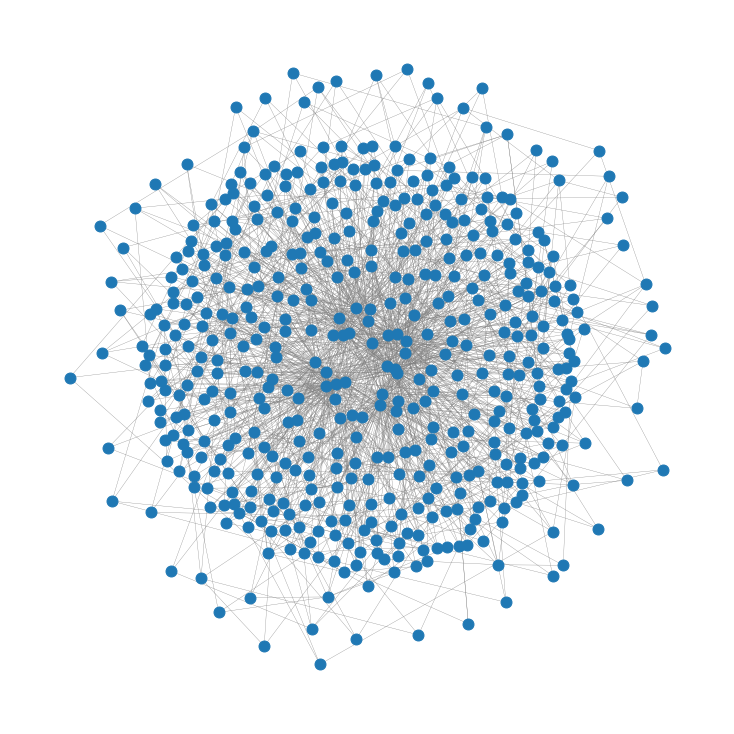

In [19]:
nx.draw(G, pos=pos, node_size=120, width=0.3, edge_color='0.5')

An interesting visualization can be obtained by plotting the nodes with a size depending on the degree: in this way we can visualize the 'sink' nodes, typical of a SF network:

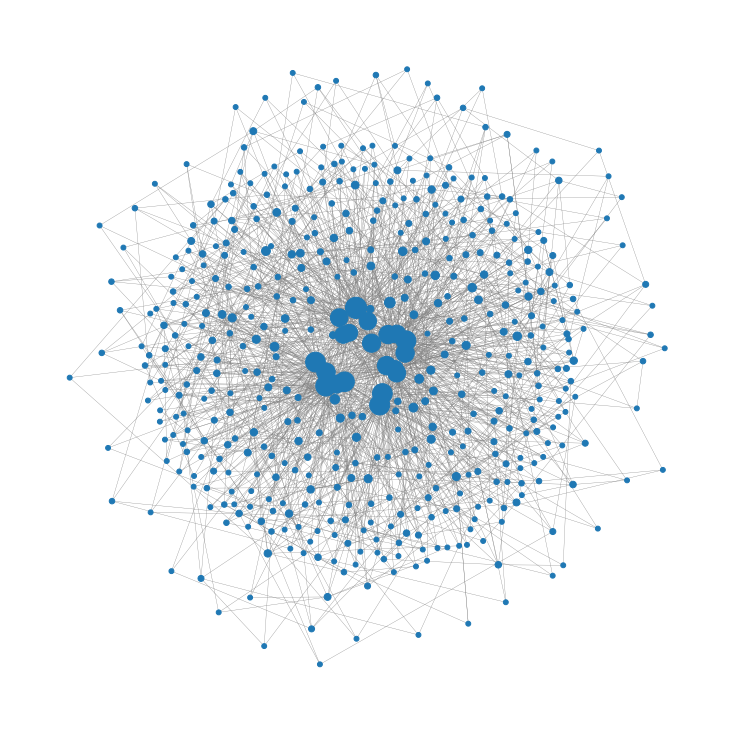

In [20]:
d = dict(G.degree) # dictionary with the degree of each node

nx.draw(G, pos=pos, node_size=[(v + 1) * 6 for v in d.values()], width=0.3, edge_color='0.5') # v + 1 to show also nodes with zero degree

As it is shown from the plot above, the network is characterized by a very few nodes with an high degree, while the majority of the nodes is characterized by very low degree values. <br>
This is a the typical behaviour in a SF network and, in particular, in a network build by following the preferential attachment mechanism.<br><br>
We can also visualize the labels of the nodes, in order to directly see which are the ones with the highest degree:

In [21]:
degree_values = list(d.values())
degree_values.sort(reverse=True)
tsh = degree_values[30] # keep first 30 'sink' nodes

sel_nodes = [n for n,v in d.items() if v > tsh] # list of 'sink' nodes

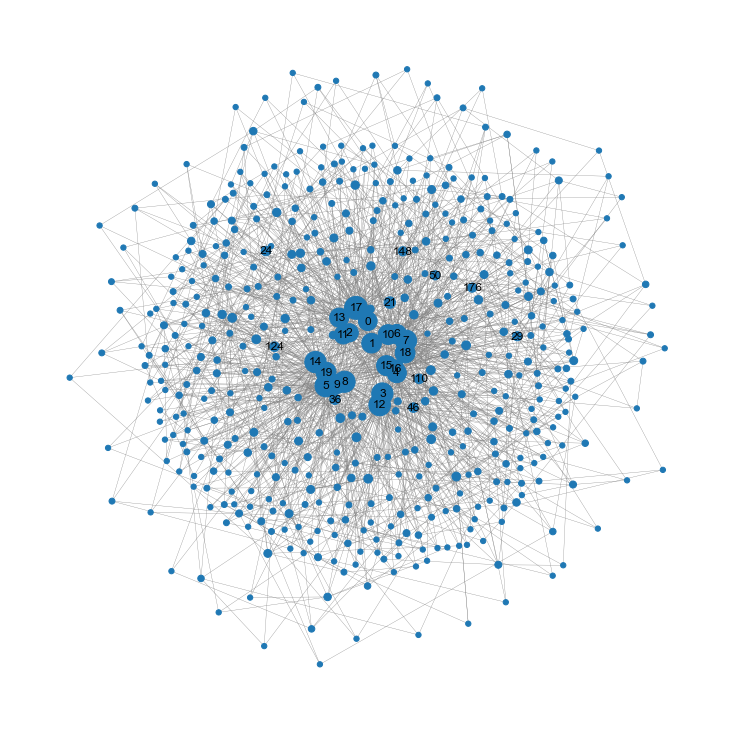

In [22]:
nodes_list = list(G.nodes())

# we create a dictionary with the labels of the nodes with a degree higher than tsh
labels = {
    n: (nodes_list[n]
        if  d[n] > tsh
        else '')
    for n in G.nodes
}

# show lables only in the 'sink' nodes
nx.draw(G, pos=pos, node_size=[(v + 1) * 7 for v in d.values()], width=0.3, edge_color='0.5', with_labels=True, labels=labels)

An alternative way to visualize 'sink' nodes could be to plot only them with all the links:

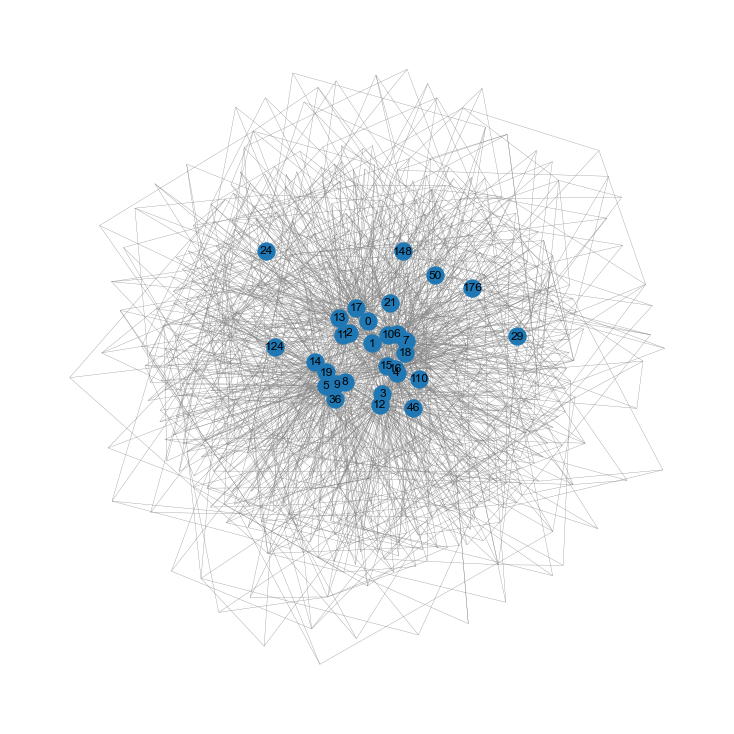

In [23]:
nx.draw(G, pos=pos, nodelist= sel_nodes, width=0.3, edge_color='0.5', with_labels=True, labels=labels)

We could mantain only the edges among 'sink' nodes in order to see the links among them, in that way we are plotting the subgraph composed by them:

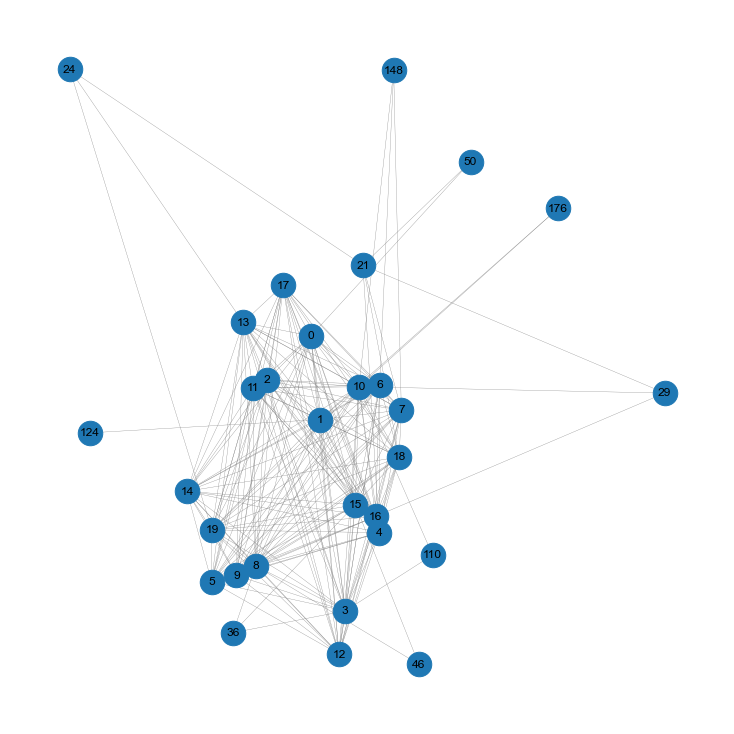

In [24]:
subG = G.subgraph(sel_nodes)
nx.draw(subG, pos=pos, nodelist= sel_nodes, width=0.3, edge_color='0.5', node_size = 600, with_labels=True, labels=labels)

As we can see, all the nodes of the initial complete graph of n_0 nodes are present among the sinks.

An alternative approach to obtain some useful insights is to plot the nodes with the highest [betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality), i.e. nodes that are traversed by a lot of shortest paths among pair of other nodes in the network:

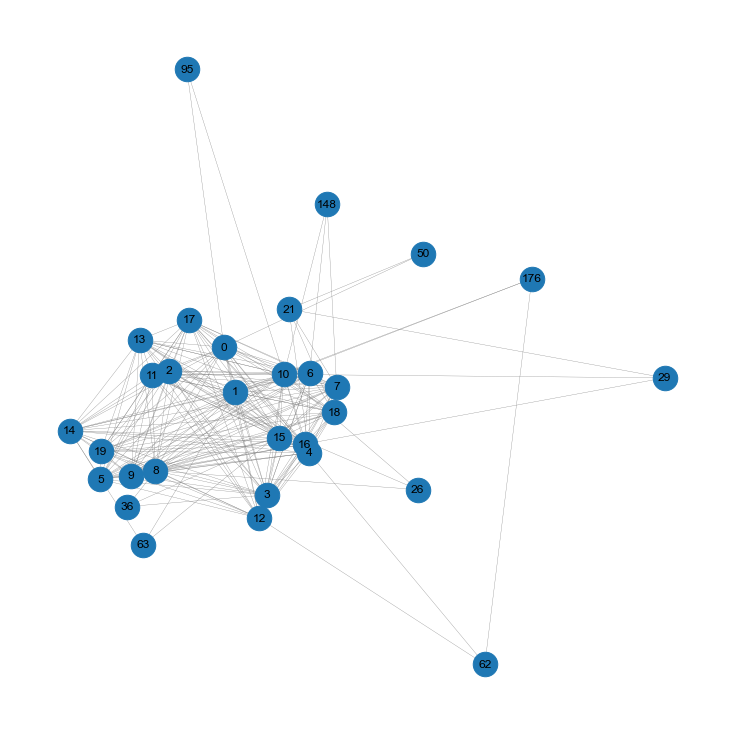

In [25]:
centr = nx.betweenness_centrality(G) # dictionary with the betweenness centrality of each node

values = list(centr.values())
values.sort(reverse=True)
tsh = values[30] # keep 30 most central nodes

sel_nodes = [n for n,v in centr.items() if v > tsh]

# we create a dictionary with the labels of the nodes with a degree higher than tsh
labels = {
    n: (nodes_list[n]
        if  centr[n] > tsh
        else '')
    for n in G.nodes
}

# Let' s plot the most central nodes, according to the betweenness centrality
subG = G.subgraph(sel_nodes)
nx.draw(subG, pos=pos, nodelist= sel_nodes, width=0.3, edge_color='0.5', node_size = 600, with_labels=True, labels=labels)

Notice that the position of the nodes in all the plots we performed is always the same (same coordinates), since we fixed the coordinates by using the Kamada-Kawai algorithm, and we always use that positioning in the draw() function.

As a further step, we can plot the so-called 'Adjacency Matrix' which draws a matrix where each row and column represent a node and each entry of the matrix represents whether there is an edge between them or not. <br>
At first let's calculate it, by using using [to_pandas_adjacency()](https://networkx.github.io/documentation/stable/reference/generated/networkx.convert_matrix.to_pandas_adjacency.html?highlight=pandas#networkx.convert_matrix.to_pandas_adjacency)

In [26]:
matrix = nx.to_pandas_adjacency(G,weight='weight')
matrix.head() # first 5 rows

0    1    2    3    4    5    6    7    8    9    ...  490  491  492  493  \
0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0  0.0   
1  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0  1.0   
2  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  1.0  0.0   
3  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  1.0  0.0  0.0   
4  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0  0.0   

   494  495  496  497  498  499  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  1.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  1.0  0.0  0.0  

[5 rows x 500 columns]

We use the [spy()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.spy.html) function of matplotlib which simply plots the sparsity of a matrix, i.e. the non-zero values.

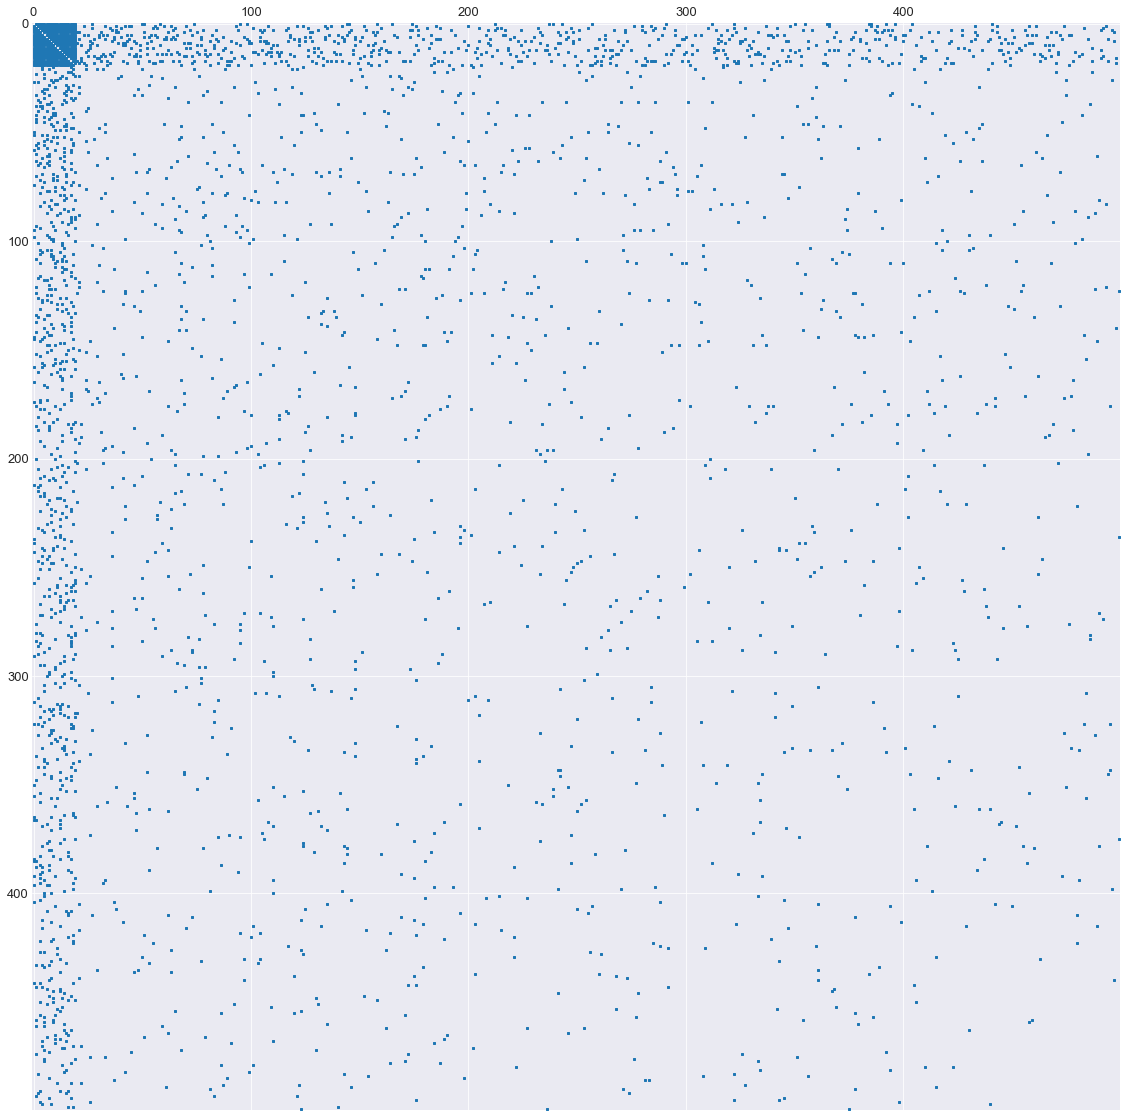

In [27]:
plt.figure(figsize=(20,20))
plt.spy(matrix, markersize= 2.0)
plt.style.use('seaborn-darkgrid')

The adjacency matrix clearly shows an high connectivity among the first initial nodes (the ones with a node id from 0 to 19), since this nodes constitute a complete graph, and therefore they are all connected to each other. <br>
Another interesting property visualized from the above graph is the high amount of links between those iniitial nodes and the rest of the nodes of the network: again, this reflects the fact that they are the 'sink' nodes of the preferential attachment based network.

### Degree distribution histograms
SF networks are characterized by a powerlaw degree distributions, where the nodes degree probability follows the equation:  P(k) = k<sup>-$\gamma$	</sup>, where k denotes the degree value and P(k) denotes the percentage of nodes with a degree equal to k. <br> <br>
It may be useful to visualize the degree distribution by using histograms. 
In this case we'll plot the histograms of the degree distributions (PDF, probability distribution function) and the complementary cumulative degree distributions (CCDF).<br>
Since the network is characterized by a powerlaw degree distribution, with a very long tail, we'll perform the plots both in linear and in log-log scale, where we expect to visualize a line.<br><br>
Let's define some auxiliary functions for plotting these histograms:

In [28]:
# create logaritmically spaced bins (for log-log histograms) by specifying the number of bins
def create_log_bins(degrees, num = 15):
    bins = np.logspace(np.log10(np.min(degrees)), np.log10(np.max(degrees)), num)
    bins = np.array(bins)
    return bins

In [29]:
plt.style.use('seaborn-darkgrid') # plot style to use for following plots

In [30]:
# PDF histogram in linear scale
def plot_linear_PDF(G, nbins = 15):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.title('PDF in linear scale')
    plt.xlabel('Degree')
    plt.ylabel('PDF')
    plt.hist(degrees, bins=nbins, density = True, cumulative = False)
    plt.tight_layout()

In [31]:
# PDF histogram in Log-Log scale
def plot_loglog_PDF(G, nbins=15):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num = nbins)
    
    plt.title('PDF in log-log scale')
    plt.xlabel('Degree')
    plt.ylabel('PDF')
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = False)
    plt.tight_layout()

In [32]:
# CCDF histogram in linear scale
def plot_linear_CCDF(G, nbins=15):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.title('CCDF in linear scale')
    plt.xlabel('Degree')
    plt.ylabel('CCDF')
    plt.hist(degrees, bins=nbins, density = True, cumulative = -1)
    plt.tight_layout()

In [33]:
# CCDF histogram in Log-Log scale
def plot_loglog_CCDF(G, nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num=nbins)
    
    plt.title('CCDF in log-log scale')
    plt.xlabel('Degree')
    plt.ylabel('CCDF')
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = -1)
    plt.tight_layout()

In [34]:
# CCDF histogram in Log-Log scale
def plot_loglog_CCDF(G, nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num=nbins)
    
    plt.title('CCDF in log-log scale')
    plt.xlabel('Degree')
    plt.ylabel('CCDF')
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = -1)
    plt.tight_layout()

In [35]:
# number of bins to use
n_bins = 12

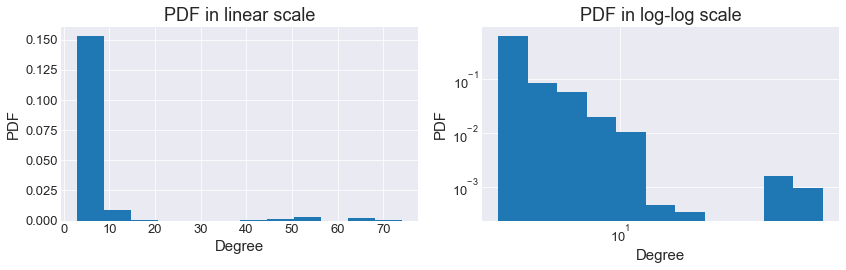

In [36]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_PDF(G, nbins=n_bins) 
plt.subplot(1, 2, 2)
plot_loglog_PDF(G, nbins=n_bins)

The histogram of the PDF clearly shows the pattern of degrees of scale-free network: the majority of the nodes has a very low degree, with a very few nodes characterized by high degree values. Being a scale-free network, in the log-log scale histogram we visualize a decreasing line.

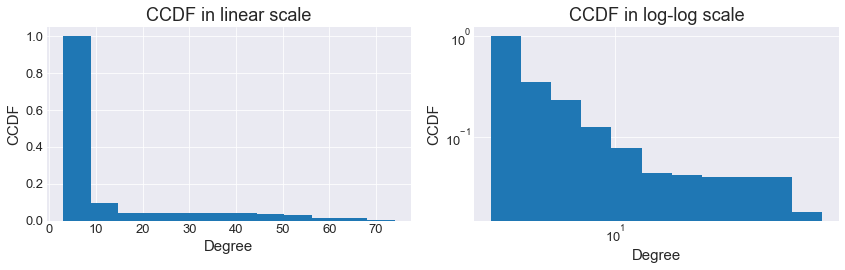

In [37]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_CCDF(G, nbins=n_bins) 
plt.subplot(1, 2, 2)
plot_loglog_CCDF(G, nbins=n_bins)

In the CCDF we can see the same behaviour as in the PDF. The histograms follow the typical pattern of a scale-free network.

### Estimation of the exponent for the empirical degree distribution
In case of a scale-free network, i.e. a network following a powerlaw degree distribution (as
the ones generated by a BA model), we may be interested in estimating the exponent of the
empirical power-law distribution.

We'll see 3 main approaches for estimating the exponent of a scale-free network:
* MLE
* Linear regression on the binned PDF histogram
* Linear regression on the binned CCDF histogram

Let's see these three approaches and then we'll compare the results obtained by each one of them

#### Using MLE
* We can use the <i>powerlaw</i> Python package described here: https://arxiv.org/abs/1305.0215, which is based on a MLE of the exponent of a powerlaw distribution . <br>
As described in the paper https://arxiv.org/abs/0706.1062, the <i>powerlaw</i> package performs the exponent estimation by following the formula 3.7 of the paper. <br>
According to the paper, the first step to perform a maximum likelihood fit to a powerlaw is to determine what portion of the data to fit. A heavy-tailed
distribution's interesting feature is, indeed, the tail and its properties, so if the initial, small values of the data
do not follow a power law distribution we may opt to disregard them. The question is from what
minimal value xmin (Kmin) the scaling relationship of the power law begins. The methods described in the paper of Clauset et al. mentioned above find this optimal value of xmin by creating a powerlaw fit starting from each unique value in the dataset, then selecting the one that results in the minimal Kolmogorov-Smirnov distance, D, between the data and the fit. Therefore the algorithm finds xmin my minimizing D. <br> <br>
* While the maximum likelihood fit to a continous power law can be calculated analytically,
and thus the optimal xmin and resulting fitted parameters can be computed quickly, this is not so for the discrete case. The maximum likelihood fit for a discrete power law is found by numerical optimization,
the computation of which for every possible value of xmin can take time. To circumvent this issue,
powerlaw can use an analytic estimate of gamma, from [https://arxiv.org/abs/0706.1062], which can "give results accurate to about 1% or
better provided xmin ≥ 6".

In [38]:
!pip install powerlaw

In [39]:
import powerlaw

degrees = [G.degree(n) for n in G.nodes()]
results = powerlaw.Fit(degrees, discrete = True)
print("\n\nExponent estimation:")
print(round(results.power_law.alpha, 4))
#print(results.power_law.xmin)

Calculating best minimal value for power law fit
xmin progress: 96%

Exponent estimation:
2.6667


#### Using Linear Regression

In [40]:
# find min and max of the degrees
Kmin = np.min(degrees)
Kmax = np.max(degrees)

Kmin, Kmax

(3, 74)

In [41]:
# calculate the logarithm of K_i for all the data elements
log_degrees = [np.log10(G.degree(n)) for n in G.nodes()]
#log_degrees

In [42]:
# calculate useful logs
log_Kmin = np.log10(Kmin)
#log_Kmax = np.log10(Kmax)
log_Kmax_1 = np.log10(Kmax + 1)
log_Kmin, log_Kmax_1

(0.47712125471966244, 1.8750612633917)

Divide the interval in equal size bins and build the bins

In [43]:
# length of the interval
interval_length = (log_Kmax_1 - log_Kmin) / n_bins

# build the bins
bins = []
for i in range(n_bins):
    bins.append(log_Kmin + interval_length * i)
bins.append(log_Kmax_1)
bins

[0.47712125471966244,
 0.5936162554423322,
 0.710111256165002,
 0.8266062568876719,
 0.9431012576103417,
 1.0595962583330114,
 1.1760912590556813,
 1.292586259778351,
 1.409081260501021,
 1.5255762612236907,
 1.6420712619463604,
 1.7585662626690304,
 1.8750612633917]

In [44]:
# Count how many elements ki have their log(ki) in each bin
counts = []
for i in range(n_bins):
    counts.append(len([deg for deg in log_degrees if deg >= bins[i] and deg < bins[i+1]]))

counts

[218, 166, 31, 37, 22, 5, 1, 0, 0, 1, 12, 7]

In [45]:
# Dividing the number of elements in each bin by the total number of elements n we get estimations for the probabilities p_b of each bin
probs = [deg/ N for deg in counts]
probs # probabilities of each bin

[0.436, 0.332, 0.062, 0.074, 0.044, 0.01, 0.002, 0.0, 0.0, 0.002, 0.024, 0.014]

In [46]:
np.sum(probs)

1.0

### Linear regression on the PDF

We now need to make the linear regression of pairs (x_b, log_pb) to obtain the regression line. <br>
Let's first calculate the elements of log_pb


In [47]:
log_PDF_p = [np.log10(p) for p in probs]
log_PDF_p

C:\Users\denal\AppData\Local\Temp\ipykernel_3784\502823365.py:1: RuntimeWarning: divide by zero encountered in log10
  log_PDF_p = [np.log10(p) for p in probs]


[-0.36051351073141397,
 -0.4788619162959637,
 -1.207608310501746,
 -1.1307682802690238,
 -1.3565473235138126,
 -2.0,
 -2.6989700043360187,
 -inf,
 -inf,
 -2.6989700043360187,
 -1.6197887582883939,
 -1.853871964321762]

We may have some infinite values: let's remove them from the list

In [48]:
# list containing indices of the infinite elements
inf_indices = []

# populate the list
for i in range(len(log_PDF_p)):
    if math.isinf(log_PDF_p[i]):
        inf_indices.append(i)
               
inf_indices

[7, 8]

In [49]:
# select only finite elements:
log_PDF_p = [v for v in log_PDF_p if not math.isinf(v)]
log_PDF_p

[-0.36051351073141397,
 -0.4788619162959637,
 -1.207608310501746,
 -1.1307682802690238,
 -1.3565473235138126,
 -2.0,
 -2.6989700043360187,
 -2.6989700043360187,
 -1.6197887582883939,
 -1.853871964321762]

The X vector of the linear regression is the bins vector, except from the first element <br>

In [50]:
X = bins[1:]

# we should select only elements corresponding to finite values of the correspondig log_PDF_p
x_2 = []
for i in range(len(X)):
    if i not in inf_indices:
        x_2.append(X[i])
X = x_2
X

[0.5936162554423322,
 0.710111256165002,
 0.8266062568876719,
 0.9431012576103417,
 1.0595962583330114,
 1.1760912590556813,
 1.292586259778351,
 1.6420712619463604,
 1.7585662626690304,
 1.8750612633917]

The Y vector of the linear regression is log_PDF_pLog_pb

In [51]:
Y = log_PDF_p
Y

[-0.36051351073141397,
 -0.4788619162959637,
 -1.207608310501746,
 -1.1307682802690238,
 -1.3565473235138126,
 -2.0,
 -2.6989700043360187,
 -2.6989700043360187,
 -1.6197887582883939,
 -1.853871964321762]

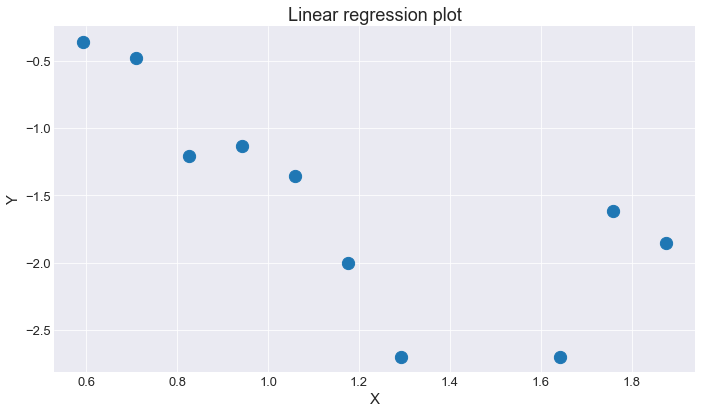

In [52]:
plt.figure(figsize=(10,6))
plt.title('Linear regression plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(X, Y, s=150)
plt.tight_layout()

Let's perform the Linear Regression by using the stats function of the scipy package

In [53]:
regr = stats.linregress(X, Y)

We are interested in the slope of the regression line, indeed the estimation of the exponent is: <br>
* gamma = -slope + 1

In [54]:
print("Slope: ", regr.slope)
exponent_estimation =  - regr.slope + 1
print("\nExponent estimation:", exponent_estimation)

Slope:  -1.3058564265346817

Exponent estimation: 2.3058564265346817


The exponent estimation, in this case, is very far from the theoretical one.

### Linear regression on the CCDF

Another alternative for the estimation of exponent gamma consists in doing exactly the same as above but for the complementary cumulative distribution function (CCDF) instead of the probability density function (PDF). <br>
CCDF is calculated from the PDF just by summing up 
the probabilities of all the bins to the right of the bin you are considering (this one included in the sum). 

In [55]:
# probabilities of the bins
probs

[0.436, 0.332, 0.062, 0.074, 0.044, 0.01, 0.002, 0.0, 0.0, 0.002, 0.024, 0.014]

In [56]:
# compute CCDF by summing on the right
CCDF_c = []
for i in range(len(probs)):
    CCDF_c.append(np.sum(probs[i:]))

In [57]:
CCDF_c

[1.0,
 0.5640000000000001,
 0.232,
 0.17,
 0.096,
 0.052,
 0.042,
 0.04,
 0.04,
 0.04,
 0.038,
 0.014]

We now need to make the linear regression of pairs (x_b and log_pb) to obtain the regression line.<br>
Let's first calculate the elements of log(cb)

In [58]:
log_CCDF_c = [np.log10(c) for c in CCDF_c]
log_CCDF_c

[0.0,
 -0.24872089601665767,
 -0.6345120151091003,
 -0.769551078621726,
 -1.0177287669604316,
 -1.2839966563652008,
 -1.3767507096020994,
 -1.3979400086720375,
 -1.3979400086720375,
 -1.3979400086720375,
 -1.4202164033831899,
 -1.853871964321762]

Again, as before, we may have infinite values that we should remove

In [59]:
# list containing indices of the infinite elements
inf_indices = []

for i in range(len(log_CCDF_c)):
    if math.isinf(log_CCDF_c[i]):
        inf_indices.append(i)
               
inf_indices

[]

In [60]:
# select only finite elements:
log_CCDF_c = [v for v in log_CCDF_c if not math.isinf(v)]
log_CCDF_c

[0.0,
 -0.24872089601665767,
 -0.6345120151091003,
 -0.769551078621726,
 -1.0177287669604316,
 -1.2839966563652008,
 -1.3767507096020994,
 -1.3979400086720375,
 -1.3979400086720375,
 -1.3979400086720375,
 -1.4202164033831899,
 -1.853871964321762]

X vector is the bins vector, except from the first element <br>

In [61]:
X = bins[1:]

# we should select only elements corresponding to finite values of the correspondig log_PDF_p
x_2 = []
for i in range(len(X)):
    if i not in inf_indices:
        x_2.append(X[i])
X = x_2
X

[0.5936162554423322,
 0.710111256165002,
 0.8266062568876719,
 0.9431012576103417,
 1.0595962583330114,
 1.1760912590556813,
 1.292586259778351,
 1.409081260501021,
 1.5255762612236907,
 1.6420712619463604,
 1.7585662626690304,
 1.8750612633917]

Y vector is the log_CCDF_c vector computed above

In [62]:
Y = log_CCDF_c

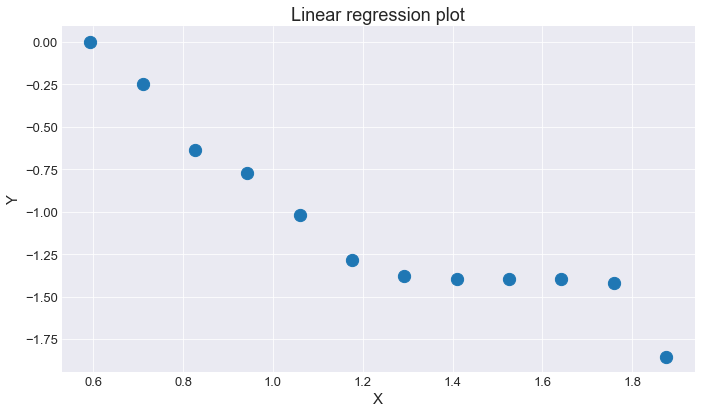

In [63]:
plt.figure(figsize=(10,6))
plt.title('Linear regression plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(X, Y, s=150)
plt.tight_layout()

Let's perform the Linear Regression by using the stats function of the scipy package: the procedure is the same as before.

In [64]:
regr = stats.linregress(X, Y)
print("Slope: ", regr.slope)
exponent_estimation =  - regr.slope + 1
print("\nExponent estimation:", exponent_estimation)

Slope:  -1.2202384299094677

Exponent estimation: 2.2202384299094677


This estimation is even worse with respect to the one obtained by using the PDF

#### Conclusion on exponent estimation
The theoretical degree distribution of a Barabasi-Albert network follows a powerlaw with an exponent $\gamma$ set to 3 (for more information: https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model).<br>

Binning-based approaches, i.e. the 2 approaches we saw based on constructing bins and performing regression on the binned data,  perform poorly. <br>
As we can easily imagine, in binning-based approaches the estimated exponent is highly dependent on the choice of bin width (here we used a fixed number of 12 bins), and this dependency varies as a function of sample size (as can be seen in this [paper](https://www.researchgate.net/publication/5369140_On_estimating_the_exponent_of_power-law_frequency_distributions)). <br>
In general, binning results in a loss of
information about the distributions of points within a
bin and is thus expected to perform poorly. Therefore, while binning is
useful for visualizing the frequency distribution, binning-based approaches should be avoided for
parameter estimation (in this [paper](https://www.researchgate.net/publication/5369140_On_estimating_the_exponent_of_power-law_frequency_distributions) more details about this). <br>

Maximum likelihood estimation performs best in estimating the powerlaw exponent.

### Plot 

We can now plot the degree distribution in linear scale and in log-log scale, showing how the degree distribution of Barabási–Albert network gives a straight line in log-log scale since it follows th equation k<sup>-3</sup>, i.e. it is a powerlaw with exponent $\gamma$ set to 3. <br><br>
Let's define some auxiliary functions for performing the plots:

In [65]:
# Plot degrees probability distributions in linear scale
def plot_distrib_lin(graph, alpha=.8, expct_lo=1, expct_hi=10):
    num_nodes = graph.number_of_nodes()

    # Calculate the maximum degree to know the range of x-axis
    max_degree = np.max([val for key,val in graph.degree()])

    # X-axis and y-axis values
    x = []
    y_tmp = []

    # Loop over all degrees until the maximum to compute the portion of nodes for that degree
    for i in range(max_degree + 1):
        x.append(i) # build x list
        y_tmp.append(0) # build y list

        for n in graph.nodes():
            if graph.degree(n) == i:
                y_tmp[i] += 1
        y = [i / num_nodes for i in y_tmp]

    plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, alpha = alpha)
    plt.title('Degree distribution (linear scale)')
    plt.ylabel('P(k)')
    plt.xlabel('k')
    plt.legend(["Real degrees"])

In [66]:
# Plot degrees probability distributions in log-log scale
def plot_distrib_log(graph, alpha=.8, fit_line=False, gam = 3,  expct_lo=1, expct_hi=10, expct_const=1):
    num_nodes = graph.number_of_nodes()

    # Calculate the maximum degree to know the range of x-axis
    max_degree = np.max([val for key,val in graph.degree()])

    # X-axis and y-axis values
    x = []
    y_tmp = []

    # Loop over all degrees until the maximum to compute the portion of nodes for that degree
    for i in range(max_degree + 1):
        x.append(i) # build x list
        y_tmp.append(0) # build y list

        for n in graph.nodes():
            if graph.degree(n) == i:
                y_tmp[i] += 1
        y = [i / num_nodes for i in y_tmp]

    plt.xscale('log')
    plt.yscale('log')
    plt.title('Degree distribution (log-log scale)')
    plt.ylabel('log(P(k))')
    plt.xlabel('log(k)')
    plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, alpha = alpha)

    if fit_line:
        # Add theoretical distribution line k^-3
        # Note that you need to parametrize it manually
        w = [a for a in range(expct_lo,expct_hi)]
        z = []
        for i in w:
            x = (i**-gam) * expct_const # set line's length and fit intercept
            z.append(x)

        plt.plot(w, z, color='#7f7f7f')
        
    plt.legend(["Real degrees", f"Powerlaw model (gamma= {-gam})"], loc='lower left')

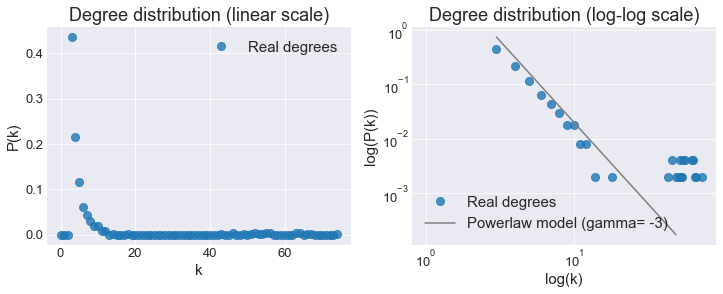

In [67]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plot_distrib_lin(graph=G)
plt.subplot(1, 2, 2)
plot_distrib_log(graph=G, fit_line=True, expct_lo=3, expct_hi=50, expct_const=20)

### Centralities
It could be interseted to visualize the centrality values of the nodes.

In [68]:
# degree centrality
deg_centrality = nx.degree_centrality(G)

In [69]:
deg_centrality

{0: 0.09819639278557113,
 1: 0.10821643286573146,
 2: 0.09218436873747494,
 3: 0.1282565130260521,
 4: 0.1062124248496994,
 5: 0.1342685370741483,
 6: 0.10420841683366733,
 7: 0.12625250501002003,
 8: 0.12625250501002003,
 9: 0.10420841683366733,
 10: 0.11022044088176351,
 11: 0.09218436873747494,
 12: 0.13226452905811623,
 13: 0.10220440881763526,
 14: 0.1282565130260521,
 15: 0.11222444889779558,
 16: 0.08617234468937875,
 17: 0.14829659318637273,
 18: 0.11022044088176351,
 19: 0.11222444889779558,
 20: 0.014028056112224447,
 21: 0.03607214428857715,
 22: 0.018036072144288574,
 23: 0.0060120240480961915,
 24: 0.024048096192384766,
 25: 0.014028056112224447,
 26: 0.018036072144288574,
 27: 0.014028056112224447,
 28: 0.008016032064128256,
 29: 0.022044088176352703,
 30: 0.014028056112224447,
 31: 0.01002004008016032,
 32: 0.01603206412825651,
 33: 0.02004008016032064,
 34: 0.01002004008016032,
 35: 0.0060120240480961915,
 36: 0.028056112224448895,
 37: 0.014028056112224447,
 38: 0.0100

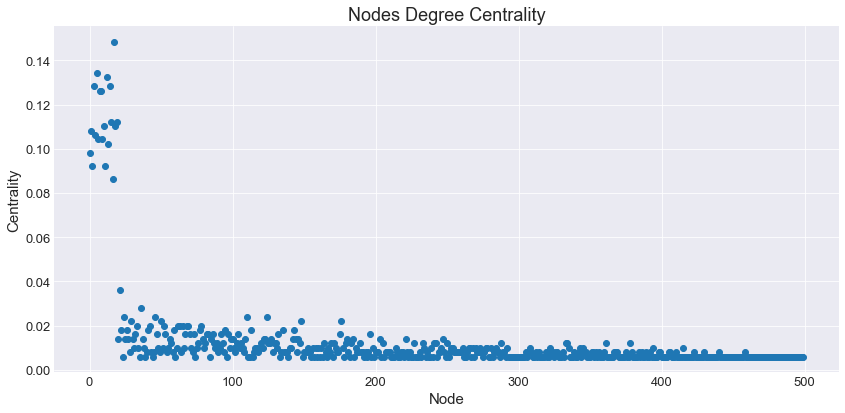

In [70]:
plt.figure(figsize=(12,6))
plt.scatter(deg_centrality.keys(), deg_centrality.values())
plt.title("Nodes Degree Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality")
plt.tight_layout()

Let's visualize the plot of the betweenness centrality:

In [71]:
# betweenness centrality
bet_centrality = nx.betweenness_centrality(G)

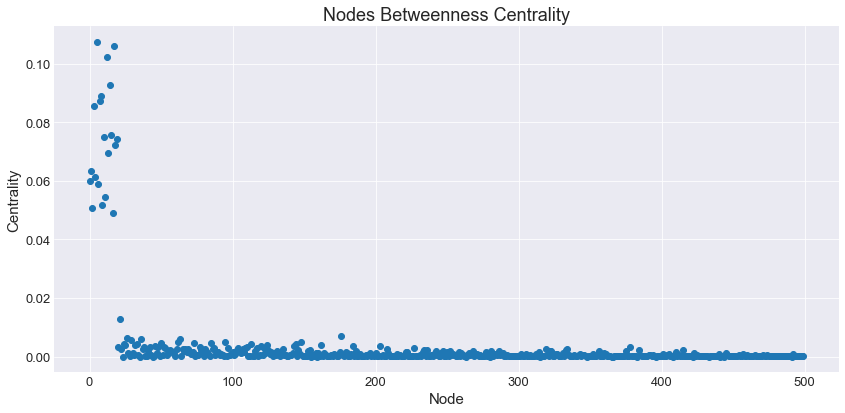

In [72]:
plt.figure(figsize=(12,6))
plt.scatter(bet_centrality.keys(), bet_centrality.values())
plt.title("Nodes Betweenness Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality")
plt.tight_layout()

Eigenvector centrality:

In [73]:
eig_centrality = nx.eigenvector_centrality(G)

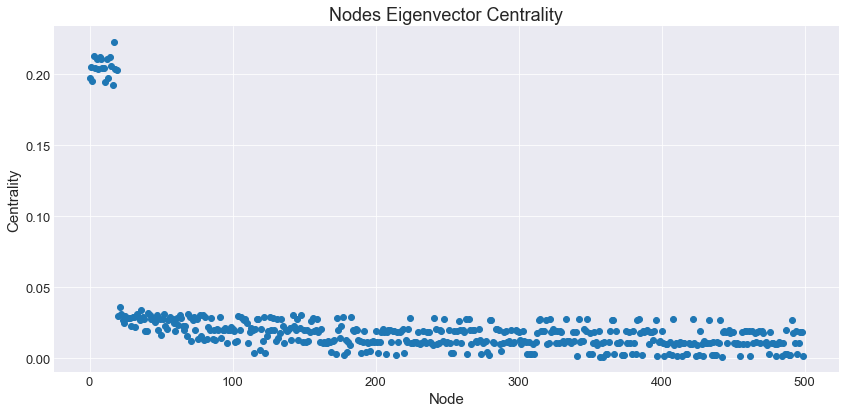

In [74]:
plt.figure(figsize=(12,6))
plt.scatter(eig_centrality.keys(), eig_centrality.values())
plt.title("Nodes Eigenvector Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality")
plt.tight_layout()

We can see that most central nodes are the initial 'seed' nodes, i.e. the ones constituting the complete graph from which we started building the preferential attachment mechanism. <br>Therefore, this is an expected behaviour, according to our implementation of the BA algorithm and reflects the properties of BA networks, characterized by a few central sink nodes.

We can even compare the 3 considered centralities:

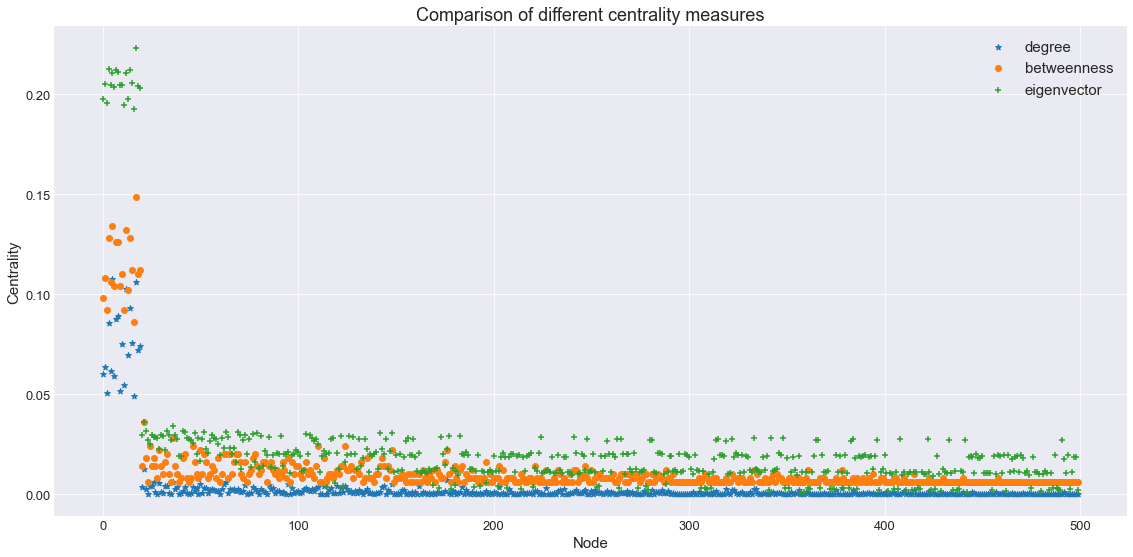

In [75]:
plt.figure(figsize=(16,8))
plt.scatter(bet_centrality.keys(), bet_centrality.values(), marker='*', label="degree")
plt.scatter(deg_centrality.keys(), deg_centrality.values(), marker='o', label="betweenness")
plt.scatter(eig_centrality.keys(), eig_centrality.values(), marker='+', label="eigenvector")
plt.title("Comparison of different centrality measures")
plt.xlabel("Node")
plt.ylabel("Centrality")
plt.legend()
plt.tight_layout()

## Community detection
One important aspect to deal with when analyzing network data is the identification of communities, i.e. clusters of nodes 'close' to each other according to some criteria. <br>
In the Complex Network theory there are many algorithms for performing community detection, which is a very hard and computationally expensive task. The different algorithms differ to each other depending on how they define the concept of cluster among nodes in a graph. <br>
We'll use some community detection algorithms implemented in the [networkx](https://networkx.org/documentation/stable/index.html#) python package and others implemented in [igraph](https://igraph.org/python/) for python.<br>
All the plots will be realized by using *networkx*, in order to have similar plots among the various partitions of each network.

## Greedy method of Newman: modularity maximization
Clauset-Newman-Moore greedy modularity maximization to find the community partition with the largest modularity. <br>
Reference paper: [https://arxiv.org/abs/cond-mat/0408187](https://arxiv.org/abs/cond-mat/0408187).<br>
The algorithm finds communities by using a modularity maximization approach: it begins with each node in its own community and repeatedly joins the pair of communities that lead to the largest modularity until no futher increase in modularity is possible. <br>

For the detailed implementation, see the [networkx](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities) reference. We apply the algorithm with the default parameters.

### Community detection

In [76]:
start_time = time.time()

communities = nx_comm.greedy_modularity_communities(G, weight='weight')

print("--- %s seconds ---" % (time.time() - start_time))

print("Number of found communities: {}".format(len(communities)))
#print("\nCommunities:")
#print(communities)

--- 0.22320270538330078 seconds ---
Number of found communities: 13


In [77]:
# first community (the largest)
#print(sorted(communities[0]))

### Modularity
Let's calculate the modularity of the graph with respect to the obtained partitioning of the vertices. <br>
It measures how strongly separated the different clusters are from each other compared to a random null model. <br>
*networkx* implementation: [https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html#networkx.algorithms.community.quality.modularity](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html#networkx.algorithms.community.quality.modularity). <br>

We use the default *resolution* parameter set to 1.

In [78]:
nx_comm.modularity(G, communities)

0.3417358575783808

### Community visualisation
Let's plot the nodes with a different colour for each identified community

In [79]:
# dict assigning to each node the corresponding community number: we need this to build a colormap
def assign_communities(G):
    part = {}

    for node in G.nodes():    
        for i in range(len(communities)):
            if node in sorted(communities[i]):
                part[node] = i
    return part

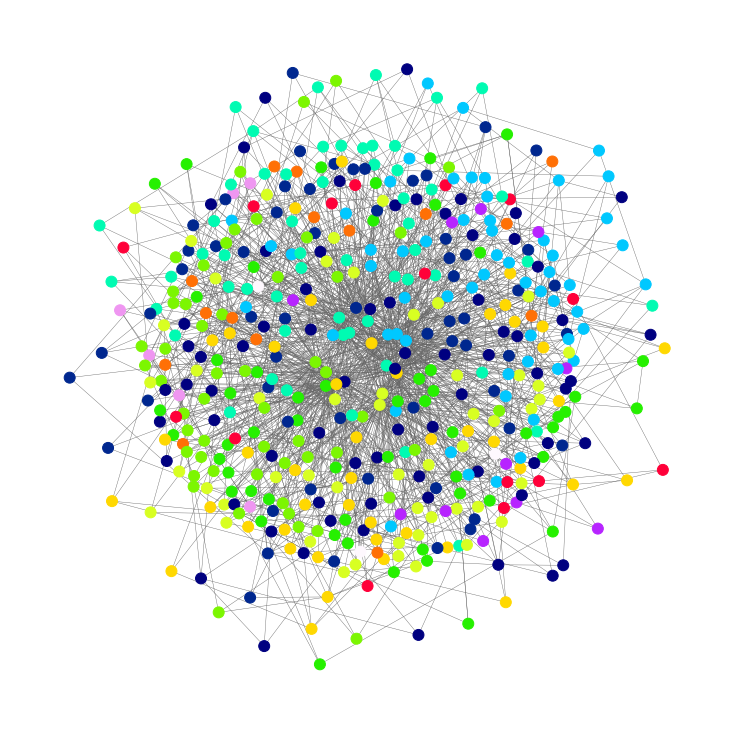

In [80]:
part = assign_communities(G)

# get colormap to color nodes according to their partition
cmap = cm.get_cmap('gist_ncar', max(part.values()) + 1)

# set plot size (also for subsequent plots)
plt.rcParams["figure.figsize"] = (10, 10)

# draw nodes, with a different color for each community
nx.draw(G, pos=pos, cmap=cmap, node_color=list(part.values()), node_size=120, width=0.4, edge_color='0.4')

## Louvain Community Detection Algorithm

The algorithm is based on the optimization of the modularity measure and a hierarchical approach. Initially, each vertex is assigned to a community on its own. In every step, vertices are re-assigned to communities in a local, greedy way: in a random order, each vertex is moved to the community with which it achieves the highest contribution to modularity. When no vertices can be reassigned, each community is considered a vertex on its own, and the process starts again with the merged communities. The process stops when there is only a single vertex left or when the modularity cannot be increased any more in a step. <br>

The algorithm is implemented in the *networkx* package, and all the details can be seen [here](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html#networkx.algorithms.community.louvain.louvain_communities). <br>
Reference paper: [https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008).

### Community detection

In [81]:
seed = 123
start_time = time.time()

communities = nx_comm.louvain_communities(G, weight='weight', seed=seed)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.05382204055786133 seconds ---


In [82]:
print("Number of found communities: {}".format(len(communities)))
#print("\nCommunities:")
#print(communities)

Number of found communities: 13


In [83]:
# first community
#print(sorted(communities[0]))

### Modularity

In [84]:
nx_comm.modularity(G, communities)

0.3376418005946781

We obtained a lower modularity value w.r.t. the Newman algorithm, even if with such a little difference we cannot say which one is preferable for a BA network

### Community visualization

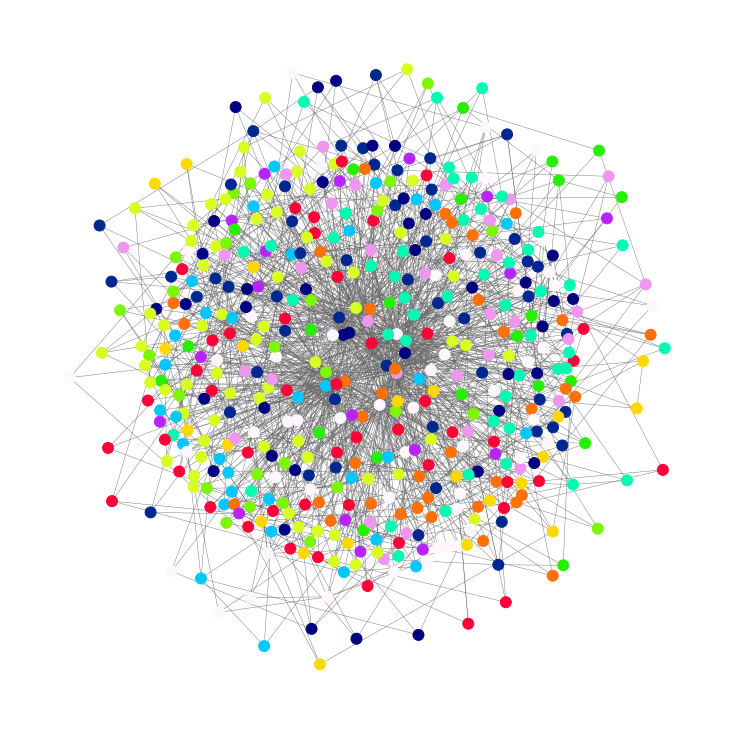

In [85]:
part = assign_communities(G)

# get colormap to color nodes according to their partition
cmap = cm.get_cmap('gist_ncar', max(part.values()) + 1)
   
# draw nodes, with a different color for each community
nx.draw(G, pos=pos, cmap=cmap, node_color=list(part.values()), node_size=120, width=0.4, edge_color='0.4')

## Spinglass community detection by Reichardt and Bornholdt 

This algorithm tries to find communities in graphs via a spin-glass model and simulated annealing. It is an approach from statistical physics, based on the so-called Potts model. In this model, each particle (i.e. vertex) can be in one of k spin states, and the interactions between the particles (i.e. the edges of the graph) specify which pairs of vertices would prefer to stay in the same spin state and which ones prefer to have different spin states. The model is then simulated for a given number of steps, and the spin states of the particles in the end define the communities. <br>

The algorithm is implemented in the *igraph* package, and all the details can be seen [here](https://igraph.org/python/api/latest/igraph.Graph.html#community_spinglass). <br>
Reference paper: [https://arxiv.org/abs/cond-mat/0603718).

In [86]:
# read the net as an igraph graph
g = ig.Graph.Read_Pajek("BA_net.net")

In [87]:
# num.vertices, num.edges, attributes for vertices and edges
ig.summary(g)

IGRAPH UNW- 500 1630 -- 
+ attr: id (v), name (v), shape (v), x (v), y (v), weight (e)


### Community detection

In [88]:
start_time = time.time()

communities = g.community_spinglass(weights=g.es["weight"])

print("--- %s seconds ---" % (time.time() - start_time))

print("Number of found communities: {}".format(len(communities)))
#print("\nCommunities:")
#print(communities)

--- 5.477365255355835 seconds ---
Number of found communities: 13


In [89]:
# first identified community
#communities.__getitem__(0)

### Modularity
*igraph* implementation of the modularity: [https://igraph.org/c/doc/igraph-Community.html#igraph_modularity](https://igraph.org/c/doc/igraph-Community.html#igraph_modularity). <br>
It is the same as the one of *networkx*

In [90]:
# in case of weighted networks, we compute the weighted modularity
mod = g.modularity(communities, weights = g.es["weight"])
mod

0.35948680793405846

This algorithm, which finds 13 different communities, has the highest modularity value so far and so it is the one performing better for the considered network

### Community visualization

In [91]:
# community of each node of the net
#print(communities.membership)

In [92]:
nodes = list(G.nodes())

In [93]:
# dict assigning to each node the corresponding community number: we need this to build a color map
part = {}

for i in range(len(communities.membership)):
    part[nodes[i]] = communities.membership[i]

#print(part)

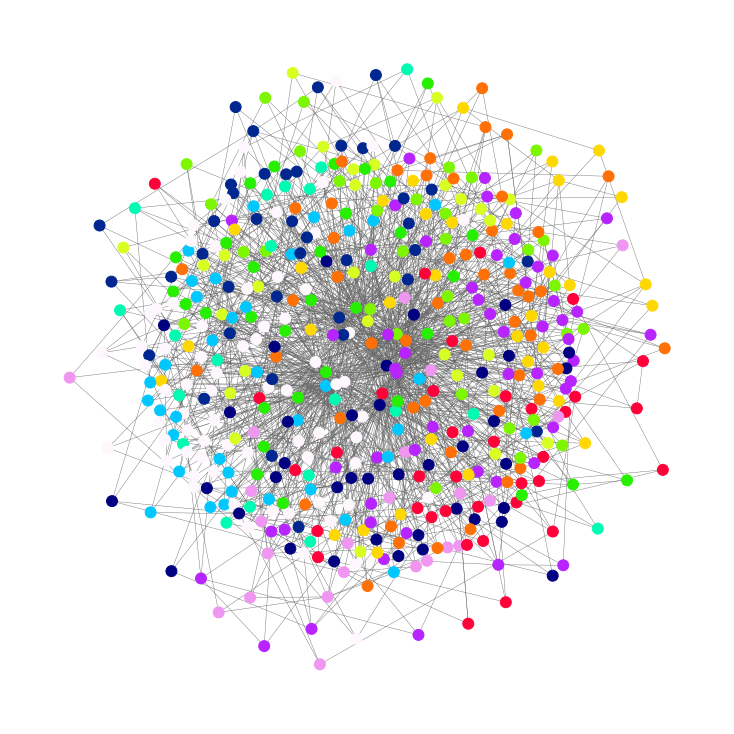

In [94]:
# get colormap to color nodes according to their partition
cmap = cm.get_cmap('gist_ncar', max(part.values()) + 1)

# draw nodes, with a different color for each community
nx.draw(G, pos=pos, cmap=cmap, node_color=list(part.values()), node_size=120, width=0.4, edge_color='0.4')

## Walktrap community detection by Pons and Latapy
Community structure based on random walks

The general idea of the algorithm is that if you perform random walks on the graph, then the walks are more likely to stay within the same community because there are only a few edges that lead outside a given community. This method runs short random walks of 3-4-5 steps (depending on one of its parameters, in our case we use the default value set to 4) and uses the results of these random walks to merge separate communities in a bottom-up manner. You can use the modularity score to select where to cut the dendrogram: in our case we'll choose the partition with the highest modularity score.<br>

The algorithm is implemented in the *igraph* package, and all the details can be seen [here](https://igraph.org/python/api/latest/igraph.Graph.html#community_walktrap). <br>
Reference paper: [https://arxiv.org/abs/physics/0512106](https://arxiv.org/abs/physics/0512106).

### Community detection

In [95]:
start_time = time.time()

communities = g.community_walktrap(weights=g.es["weight"])

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0109710693359375 seconds ---


In [96]:
# in this case the output is a dendrogram, i.e. a hierarchy of partitions
communities

In [97]:
print(communities)

Dendrogram, 500 elements, 499 merges


In [98]:
# Cut the dendogram in the max modularity level
communities = communities.as_clustering()
print("Number of found communities: {}".format(len(communities)))
#print("\nCommunities:")
#print(communities)

Number of found communities: 61


In [99]:
#communities.__getitem__(0)

### Modularity

In [100]:
mod = g.modularity(communities, weights = g.es["weight"])
mod

0.252978282961346

Very low modularity value: the algorithm is not correctly finding the communities

### Community visualization

In [101]:
# community of each node of the net
#print(communities.membership)

In [102]:
# dict assigning to each node the corresponding community number: we need this to build a color map
part = {}

for i in range(len(communities.membership)):
    part[nodes[i]] = communities.membership[i]

#print(part)

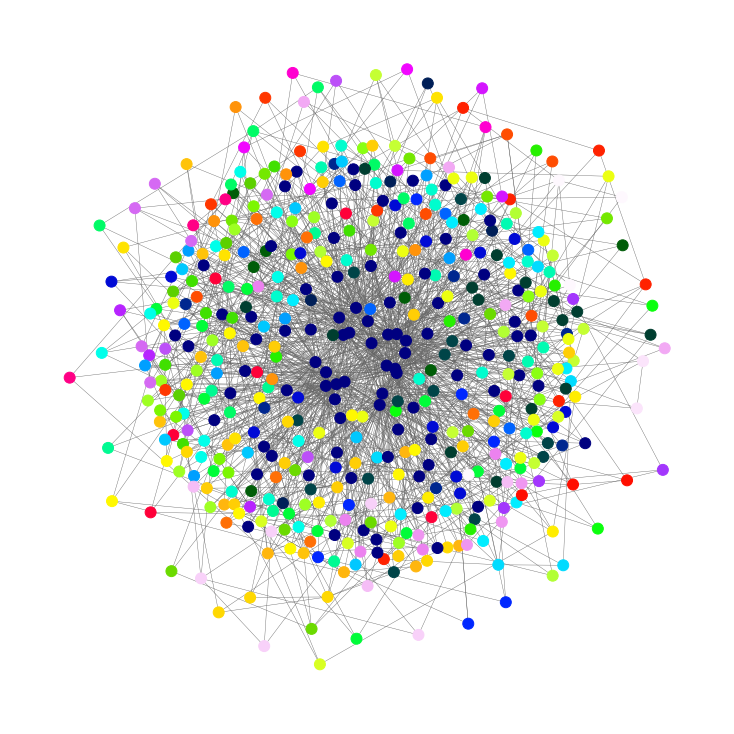

In [103]:
# get colormap to color nodes according to their partition
cmap = cm.get_cmap('gist_ncar', max(part.values()) + 1)

# draw nodes, with a different color for each community
nx.draw(G, pos=pos, cmap=cmap, node_color=list(part.values()), node_size=120, width=0.4, edge_color='0.4')

## Girvan–Newman (GN)
The GN algorithm is one of the most famous community detection algorithm and also one of the most intuitive. The specificity of this algorithm is the use of **betweeness centrality** of an edge: the number of shortest path between nodes in which this edge is part of. <br>
The idea is that the betweenness of the edges connecting two communities is typically high, as many of the shortest paths between nodes in separate communities go through them. So we gradually remove the edge with highest betweenness from the network, and recalculate edge betweenness after every removal. This way sooner or later the network falls off to two components, then after a while one of these components falls off to two smaller components, etc. until all edges are removed. This is a divisive hierarchical approach, the result is a dendrogram (again we choose the partition corresponding to the max modularity value). <br>

The algorithm is implemented in the *igraph* package, and all the details can be seen [here](https://igraph.org/python/api/latest/igraph.Graph.html#community_edge_betweenness). <br>
Reference paper: [https://arxiv.org/abs/cond-mat/0112110](https://arxiv.org/abs/cond-mat/0112110).

### Community detection

In [104]:
start_time = time.time()

communities = g.community_edge_betweenness()

print("--- %s seconds ---" % (time.time() - start_time))

--- 16.16618299484253 seconds ---


In [105]:
# in this case the output is a dendrogram, i.e. a hierarchy of partitions
communities

In [106]:
print(communities)

Dendrogram, 500 elements, 499 merges


In [107]:
# Cut the dendogram in the max modularity level
communities = communities.as_clustering()
print("Number of found communities: {}".format(len(communities)))
#print("\nCommunities:")
#print(communities)

Number of found communities: 55


In [108]:
#communities.__getitem__(0)

### Modularity

In [109]:
mod = g.modularity(communities, weights = g.es["weight"])
mod

0.2914091610523541

This algorithm doesn't perform the modularity value we obtained through the 'Spinglass' algorithm.

### Community visualization

In [110]:
# community of each node of the net
print(communities.membership)

[0, 0, 1, 0, 0, 2, 1, 0, 2, 2, 1, 3, 1, 3, 3, 1, 4, 1, 5, 6, 1, 2, 7, 0, 3, 2, 8, 0, 5, 9, 10, 1, 11, 12, 13, 5, 14, 15, 0, 2, 16, 0, 1, 17, 0, 0, 0, 3, 10, 1, 12, 18, 19, 20, 2, 5, 21, 1, 1, 2, 0, 22, 23, 24, 1, 25, 24, 26, 19, 12, 26, 22, 0, 27, 2, 3, 3, 3, 1, 3, 1, 28, 29, 30, 0, 31, 26, 12, 3, 32, 25, 3, 33, 19, 0, 34, 19, 35, 34, 36, 37, 3, 3, 11, 16, 38, 38, 3, 2, 39, 2, 10, 1, 27, 1, 31, 29, 38, 29, 2, 21, 30, 40, 12, 1, 1, 1, 33, 2, 3, 19, 33, 26, 6, 0, 20, 1, 41, 26, 20, 42, 26, 28, 43, 20, 0, 44, 6, 38, 27, 2, 1, 0, 9, 26, 6, 1, 2, 0, 6, 3, 16, 24, 29, 19, 10, 26, 33, 3, 45, 12, 40, 9, 1, 10, 0, 18, 0, 35, 38, 27, 46, 27, 2, 14, 0, 0, 0, 1, 2, 44, 47, 28, 19, 37, 34, 11, 19, 25, 31, 2, 43, 11, 48, 4, 2, 6, 3, 49, 0, 30, 1, 0, 1, 50, 5, 25, 2, 20, 3, 1, 12, 1, 24, 1, 3, 19, 49, 1, 1, 29, 13, 24, 0, 14, 43, 51, 0, 37, 31, 12, 2, 2, 50, 3, 0, 42, 46, 2, 1, 36, 7, 46, 0, 39, 1, 6, 2, 5, 3, 26, 47, 1, 1, 0, 52, 43, 3, 52, 3, 14, 21, 0, 39, 1, 9, 30, 53, 36, 34, 6, 15, 47, 33, 12, 

In [111]:
# dict assigning to each node the corresponding community number: we need this to build a color map
part = {}

for i in range(len(communities.membership)):
    part[nodes[i]] = communities.membership[i]

#print(part)

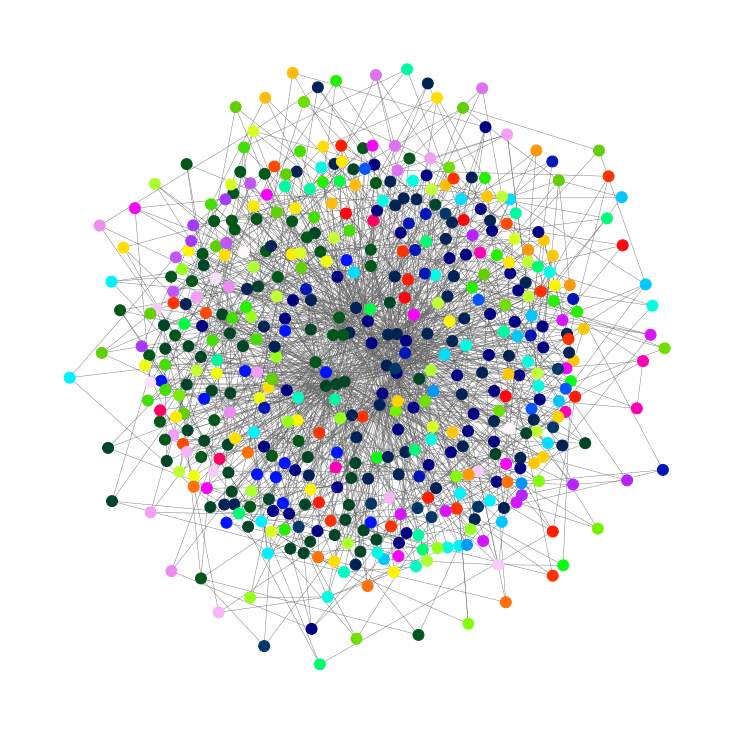

In [112]:
# get colormap to color nodes according to their partition
cmap = cm.get_cmap('gist_ncar', max(part.values()) + 1)

# draw nodes, with a different color for each community
nx.draw(G, pos=pos, cmap=cmap, node_color=list(part.values()), node_size=120, width=0.4, edge_color='0.4')

# Epidemic Spreading

## Monte Carlo simulation of SIS epidemic spreading
Monte Carlo simulation of an epidemic spreading dynamics in complex networks, using the SIS model in which each node represents an individual which can be in two possible states: 
* Susceptible (S), i.e., healthy but can get infected
* Infected (I), i.e., has the disease and can spread it to its neighbors.

We are interested in the calculation of the fraction of infected nodes, ρ, in the stationary state (when ρ gets a stationary value, as a function of the infection probability of the disease β, for different values of the recovery probability μ (e.g. 0.1, 0.5, 0.9). 

## Auxiliary functions

### Simulation function
The function below performs 1 full simulation of SIS epidemic spreading. <br>
Since this function is very expensive and it needs to be called at each performed simulation, we declare it as a c function and we add also some static binding for some of the used variables (by using cython). <br>
In this way we greatly improve the performance of the algorithm. <br><br>
The simulation function takes in input:
* the graph g and its length
* the array of initial states (randomly generated): it is an array of the same size as the one of the network, where each cell indicates the state of the corresponding node (1 stands for I and 0 stands for S)
* the 2 main paramters of the SIS model, i.e. µ and β

The function performs TMAX iterations and it returns the average of ρ(t) calcualated considering the mean of the ρ values obtained after TTRANS iterations, when we assume that the system has 
reached the stationary state. <br>

Indeed, the simulation requires also 2 extra parameters:
* TMAX  maximum number of time steps of each simulation
* TTRANS  number of steps of the transitory

In [113]:
%%cython
import numpy as np
import igraph as ig
from libc.math cimport pow # import C pow function
from libc.stdlib cimport rand, srand, RAND_MAX # import C random functions
from libc.time cimport time,time_t # import C time function

def simulation(g, int len_g, char[:] state, double mu, double beta):
    
    """
    Applies one simulation to the graph in argument and returns 
    the average infection rate over the stationary time steps
    """ 
    
    # Constants
    cdef int TMAX = 1000 # maximum number of time steps of each simulation
    cdef int TTRANS = 900 # number of steps of the transitory
    
    # Declared variables
    cdef double[:] infected_ratio_list = np.zeros(TMAX - TTRANS) # infection ratio at each step of the stationary
    cdef int i, j, v, n # counters
    cdef int infected_vertices # number of infected neighbors
    cdef char[:] old_state = np.zeros(len_g, dtype = np.int8) # array of the states of the nodes in the previous iteration
    cdef double prob # probability value between 0 and 1
    cdef double a = RAND_MAX
    cdef int num_infected = 0 # counter of the number of infected vertices at each time step
    
    # set random seed 
    srand(time(NULL)) 
    
    #simulation loop
    for i in range(TMAX):
        
        if i >= TTRANS:
            num_infected = 0
            
        # copy old state
        for j in range(len_g):
            old_state[j] = state[j]
        
        # update states of all nodes
        for j in range(len_g):
            
            # if old node state is I
            if old_state[j]:
                prob = rand() / a # generate random number in [0, 1]
                if prob < mu: # update new state
                    state[j] = 0 
                else:
                    state[j] = 1
                
            # if old node state is S
            else:
                infected_vertices = 0  # counter of the infected vertices of current SUSCECTIBLE node
                
                for n in g.neighbors(j):
                    infected_vertices += old_state[n]
                prob = rand() / a
                if prob < pow(1 - beta, infected_vertices):
                    state[j] = 0
                else:
                    state[j] = 1
                    
            # we compute infection ratio from iteration 900
            if i >= TTRANS:
                num_infected += state[j]
            
        if i >= TTRANS:
            infected_ratio_list[i - TTRANS] = num_infected/len_g

    # returns the average infected ratio (calculated only over the stationary)    
    return np.mean(np.array(infected_ratio_list)) 

### Perform n simulations

Let's define an auxiliary function for performing NREP simulations


In [114]:
NREP = 100

In [115]:
!pip install tqdm
from tqdm.notebook import tqdm
def perform_n_iterations(g, len_g, MU, BETA, n=NREP):
    
    start_t = time.time()
    infected_ratio_list = np.zeros(NREP) # vector with avg infection ratio of each simulation
    
    for i in tqdm(range(NREP), desc=f'mu={MU}, beta={BETA}'):
    #for i in range(NREP):
        
        start_time = time.time()
        state = np.array(np.random.binomial(1, P0, size=len_g), dtype=np.int8) # initial state
        
        infected_ratio_list[i] = simulation(g, len_g, state, MU, BETA)
        #print("Time required by simulation {}: {} seconds".format(i+1, time.time()-start_time))
    #print("\nTime required by {} simulations: {} seconds\n\n".format(n, time.time() - start_t))
    
    return np.mean(infected_ratio_list) # return average of averages over 100 iterations

### Iterate over β
We need now to iterate over different beta values

In [116]:
def iterate_over_beta(g, len_g, MU, beta_list): # notice that MU is given
    # avg ρ for each β
    avg_over_beta = np.zeros(len(beta_list))
    
    for i, beta in enumerate(tqdm(beta_list, desc=f'Avg betas, mu={mu}')):
        #print("Calculate value for beta = {} (mu = {})".format(beta, MU))
        avg_over_beta[i] = perform_n_iterations(g, len_g, MU, beta, NREP) 
        
    # returns the value for each beta value given the MU value
    return avg_over_beta 

## Microscopic Markov Chain Approach (MMCA) model
Auxiliary function for applying the MMCA approach, which allows to capture the microsopic dynamics at the individual level by computing the probability that any node is infected in the steady state. <br> In particular, we consider a reactive process, i.e. we assume that each node contacts all of his neighbors at each time step, and we formulate the MMCA for the case without one-step reinfections, i.e. only nodes suscetible at the beginning of the time step can be infected. <br>
The MMCA model equation, to be solved iteratively is the following:<br>
<h4><center>pi(t + 1) = (1 − pi(t))(1 − qi(t)) + (1 − μ)pi(t)</center></h4> <br>

Where:
* pi(t) represents the probability of node i being infected at time step i
* qi(t) represents the probability that a node is not being infected by any neighbor

At the end, we'll compare the ρ(β) result from Monte Carlo simulations with the theoretical prediction provided by the Microscopic Markov Chain Approach (MMCA) model. <br>
Again, we use cython to speedup the computation.



In [117]:
%%cython
import numpy as np
import igraph as ig

def MMCA_model(g, int len_g, double[:] probs, double mu, double beta):
    
    """
    Applies iteratively the MMCA equation to the graph in argument and returns the average infection rate over the last 2 steps
    """ 
    
    # Constants
    cdef int TMAX = 1000 # maximum number of iterations of the equation    
    
    # Declared variables
    cdef int i, j, v # counters
    cdef double[:] old_probs = np.zeros(len_g) # array of node probabilites of being infected in the previous step
    cdef double q_i # probability that a node is not infected by any neighbour
    
    #equation iterations
    for i in range(TMAX):
             
        # copy old probabilities
        for j in range(len_g):
            old_probs[j] = probs[j]
        
        # apply equation to each node
        for j in range(len_g):
            q_i = 1 # initialize q_i
            
            # compute the probability that current node is NOT infected by any neighbor
            for v in g.neighbors(j):
                q_i = q_i * (1 - beta * old_probs[v])
            
            # apply equation to obtain the new probaility of being infected
            probs[j] = (1 - old_probs[j]) * (1 - q_i) + (1 - mu) * old_probs[j]

   
    return ((np.mean(probs) + np.mean(old_probs)) / 2)

In order to perform the calculations over multiple beta values:

In [118]:
def iterate_over_beta_MMCA(g, len_g, MU, beta_list): # notice that MU is given
    # ρ for each β 
    ro_over_beta = np.zeros(len(beta_list))
    
    for i, beta in enumerate(tqdm(beta_list, desc=f'MMCA')):
        probs = np.full(len_g, P0) # array with initial node probabilities of being infected
        ro_over_beta[i] = MMCA_model(g, len_g, probs, MU, beta)
    # returns the value for each beta value given the MU value
    return ro_over_beta

## Simulation

In [119]:
# probability of initial infection
P0 = 0.2

### Lists

In [120]:
STEP_BETA = 0.02

mu_list = [0.1, 0.5, 0.9]
beta_list = np.arange(0.00, 1.00, STEP_BETA) # 50 VALUES WITH delta beta = 0.02

In [121]:
len(beta_list) 

50

In [122]:
beta_list

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

### Perform the simulation

In [123]:
values_per_mu = []
values_per_mu_MMCA = []
start_time = time.time()

for mu in tqdm(mu_list, desc='General progress bar'):
    print("Computing value for mu = {}\n".format(mu))
    values_per_mu.append(iterate_over_beta(g, len(G.nodes()), mu, beta_list)) 
    values_per_mu_MMCA.append(iterate_over_beta_MMCA(g, len(G.nodes()), mu, beta_list))
    
print("Total required time: {} seconds".format(time.time() - start_time))

General progress bar:   0%|          | 0/3 [00:00<?, ?it/s]

Computing value for mu = 0.1



Avg betas, mu=0.1:   0%|          | 0/50 [00:00<?, ?it/s]

mu=0.1, beta=0.0:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.02:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.04:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.06:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.08:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.1:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.12:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.14:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.16:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.18:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.2:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.22:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.24:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.26:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.28:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.3:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.32:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.34:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.36:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.38:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.4:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.42:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.44:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.46:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.48:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.5:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.52:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.54:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.56:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.58:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.6:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.62:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.64:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.66:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.68:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.7000000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.72:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.74:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.76:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.78:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.8:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.8200000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.84:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.86:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.88:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.9:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.92:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.9400000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.96:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.1, beta=0.98:   0%|          | 0/100 [00:00<?, ?it/s]

MMCA:   0%|          | 0/50 [00:00<?, ?it/s]

Computing value for mu = 0.5



Avg betas, mu=0.5:   0%|          | 0/50 [00:00<?, ?it/s]

mu=0.5, beta=0.0:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.02:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.04:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.06:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.08:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.1:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.12:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.14:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.16:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.18:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.2:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.22:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.24:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.26:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.28:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.3:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.32:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.34:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.36:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.38:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.4:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.42:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.44:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.46:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.48:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.5:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.52:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.54:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.56:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.58:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.6:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.62:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.64:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.66:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.68:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.7000000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.72:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.74:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.76:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.78:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.8:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.8200000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.84:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.86:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.88:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.9:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.92:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.9400000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.96:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.5, beta=0.98:   0%|          | 0/100 [00:00<?, ?it/s]

MMCA:   0%|          | 0/50 [00:00<?, ?it/s]

Computing value for mu = 0.9



Avg betas, mu=0.9:   0%|          | 0/50 [00:00<?, ?it/s]

mu=0.9, beta=0.0:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.02:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.04:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.06:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.08:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.1:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.12:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.14:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.16:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.18:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.2:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.22:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.24:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.26:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.28:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.3:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.32:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.34:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.36:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.38:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.4:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.42:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.44:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.46:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.48:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.5:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.52:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.54:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.56:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.58:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.6:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.62:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.64:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.66:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.68:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.7000000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.72:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.74:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.76:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.78:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.8:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.8200000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.84:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.86:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.88:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.9:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.92:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.9400000000000001:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.96:   0%|          | 0/100 [00:00<?, ?it/s]

mu=0.9, beta=0.98:   0%|          | 0/100 [00:00<?, ?it/s]

MMCA:   0%|          | 0/50 [00:00<?, ?it/s]

Total required time: 1756.2252705097198 seconds


In [124]:
values_per_mu

[array([3.082000e-04, 2.982112e-01, 5.150546e-01, 6.363794e-01,
        7.039520e-01, 7.441266e-01, 7.753052e-01, 7.995940e-01,
        8.175064e-01, 8.333586e-01, 8.445066e-01, 8.523632e-01,
        8.585354e-01, 8.647610e-01, 8.708344e-01, 8.764128e-01,
        8.813842e-01, 8.838810e-01, 8.868500e-01, 8.894564e-01,
        8.915858e-01, 8.941398e-01, 8.945988e-01, 8.982188e-01,
        8.985912e-01, 9.000822e-01, 9.007546e-01, 9.022156e-01,
        9.027576e-01, 9.036198e-01, 9.039564e-01, 9.050270e-01,
        9.056448e-01, 9.065124e-01, 9.057444e-01, 9.070312e-01,
        9.065032e-01, 9.078194e-01, 9.078060e-01, 9.086648e-01,
        9.079438e-01, 9.087442e-01, 9.089054e-01, 9.081694e-01,
        9.074564e-01, 9.084024e-01, 9.085926e-01, 9.084664e-01,
        9.089172e-01, 9.099330e-01]),
 array([4.320000e-05, 2.642000e-04, 6.102280e-02, 1.386862e-01,
        2.007940e-01, 2.529706e-01, 3.009038e-01, 3.410434e-01,
        3.765398e-01, 4.079146e-01, 4.346948e-01, 4.589710e-01,
  

### Final Plot (MC simulations and comparison with MMCA)
The continuous line represents the MC simulation results, while the points represent the result from the MMCA model.

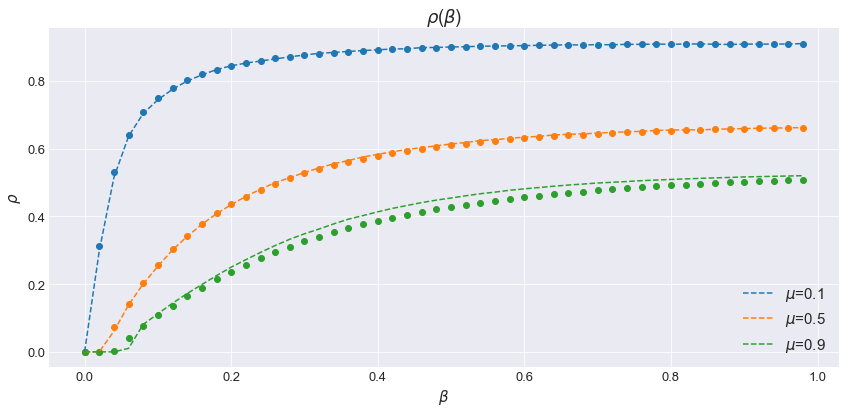

In [128]:
plt.figure(figsize=(12,6))
for i in range(len(mu_list)):
    plt.plot(beta_list, values_per_mu[i], label=r'$\mu$' + '={}'.format(mu_list[i]), linestyle='dashed')
    plt.scatter(beta_list, values_per_mu_MMCA[i])
    plt.title(r'$\rho$($\beta$)')
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$\rho$')
    plt.legend(loc='lower right')
    plt.tight_layout()

We can see that having a lower recovery rate leads the infection ratio to be higher, which makes sense as less individuals tends to recover from the infection. <br>
For what regards the MC and the MMCA comparison, we can see that the prevalence curves are completely overlapped for low values of the recovery rate, while we have some differences for high recovery rate, especially for values of beta between 0.4 and 0.8